In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation

# Introduction
In this notebook, we simulate a 2D ideal gas confined in a box (1 by 1), to verify that it gradually relaxes to the Maxwell-Boltzmann probability distribution of velocities. The assumptions about the gas particles are listed below. 
## Assumptions
* All gas particles are rigid circular bodies, of equal mass.
* All collisions are elastic.
* The walls are of inifinite mass.
* No energy flows into or out of the system.

[Read more about the Maxwell-Boltzmann Distribution](https://en.wikipedia.org/wiki/Maxwell%E2%80%93Boltzmann_distribution)

We'll use **matplotlib** for the plotting and animation, and **numpy** for the calculations.

First, We create N(=500) particles, which are essentially randomly generated 2D position vectors associated with each particle. We also define the radius(=0.005) of each particle, later used during collision detection.

In [2]:
N = 500
radius = 0.005
V = 0.03
rx = np.random.random(N)
ry = np.random.random(N)
r = []
for i in range(N):
    r.append(np.array([rx[i], ry[i]]))
r = np.array(r)
v = np.zeros(r.shape)

Let's visualize the particles using matplotlib

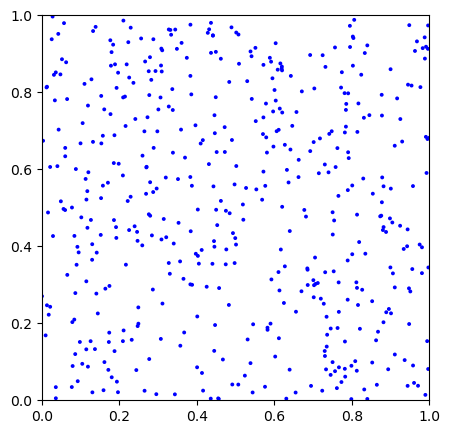

In [3]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
circles = [plt.Circle((r[i]), radius=radius, linewidth=0) for i in range(N)]
cred = matplotlib.collections.PatchCollection(circles, facecolors='blue')
ax.add_collection(cred)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()

We assign the initial velocities to the particles as such:
* If the particle's above the y = 0.5 line, it goes downwards
* If the particle's below the y = 0.5 line, it goed upwards

**Note: We can start with a random distribution of initial velocities as well**

In [4]:
for i in range(N):
    if r[i,1] >= 0.5:
        v[i,1] = -V
    elif r[i,1] < 0.5:
        v[i,1] = V

### The Simulation
* The simulation runs for T(=400) frames.
* In each iteration we push a copy of the position vectors of each particle into the `R_sim` array
* We check for collisions between particles by checking every pair of particles by checking of $|\vec{r_1} - \vec{r_2}| < 2r$ and after detecting the collisions we change the velocities of the particles using the following formulae: 
$$\boxed{\vec{v'_1} = \vec{v_1} - \frac{(\vec{v_1} - \vec{v_2})\cdot(\vec{r_1} - \vec{r_2})}{|\vec{r_1} - \vec{r_2}|^2} (\vec{r_1} - \vec{r_2})}$$
$$\boxed{\vec{v'_2} = \vec{v_2} - \frac{(\vec{v_2} - \vec{v_1})\cdot(\vec{r_2} - \vec{r_1})}{|\vec{r_2} - \vec{r_1}|^2} (\vec{r_2} - \vec{r_1})}$$

    These formulae come from the conservation of linear momentum and kinetic energy, since the collisions are elastic. 

    For the collisions with walls, we just flip the component of velocity perpendicular to the colliding wall.
    This method of collision detection is highly inefficient, and also, it has bugs. That will be discussed at the end of the notebook.
* We update the position vectors using the updated velocties.


In [5]:
T = 400
R_sim = []
speeds = []
for _ in range(T):
    R_sim.append(r.copy())
    speeds.append(np.array([np.linalg.norm(v[i]) for i in range(N)]))
    checked = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            if j != i and checked[i][j] != 1:
                checked[i][j] = 1
                checked[j][i] = 1
                d = np.linalg.norm(r[i] - r[j])
                if d <= 2*radius:
                    vinew = v[i] - (np.dot(v[i] - v[j], r[i] - r[j]) / d**2)*(r[i] - r[j])
                    vjnew = v[j] - (np.dot(v[j] - v[i], r[j] - r[i]) / d**2)*(r[j] - r[i])
                    v[i] = vinew.copy()
                    v[j] = vjnew.copy()
    for i in range(N):
        for k in [0,1]:
            if r[i, k] <= radius:
                v[i, k] = np.abs(v[i, k])
            if r[i, k] >= 1 - radius:
                v[i, k] = -np.abs(v[i, k])
    for i in range(N):
        r[i] += v[i]
R_sim = np.array(R_sim)
speeds = np.array(speeds)

## Creating the animation

* We animate this using `matplotlib.animation.FuncAnimation`

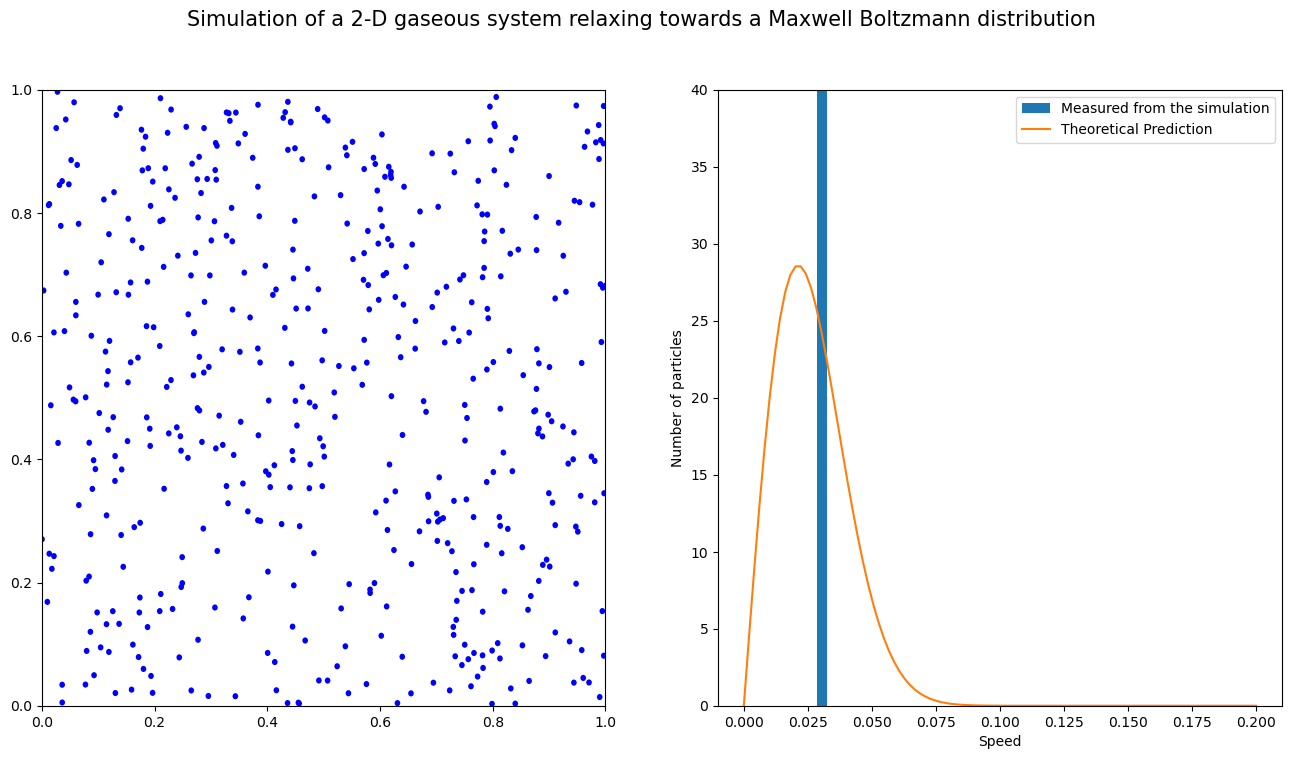

In [7]:
fig, axes = plt.subplots(1,2,figsize=(16,8))
fig.suptitle("Simulation of a 2-D gaseous system relaxing towards a Maxwell Boltzmann distribution", fontsize=15)
bins = np.linspace(0, 0.2, 50)
def animate(i):
    [ax.clear() for ax in axes]
    ax = axes[0]
    ri = R_sim[i]
    particles = [plt.Circle(ri[j], radius=radius, linewidth=0) for j in range(N)]
    cred = matplotlib.collections.PatchCollection(particles, facecolors='blue')
    ax.add_collection(cred)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax = axes[1]
    ax.set_ylim(0, 40)
    ax.hist(speeds[i], density=True, bins=bins, label="Measured from the simulation")
    ax.set_xlabel("Speed")
    ax.set_ylabel("Number of particles")
    x = np.linspace(0, 0.2, 100)
    a = 2/V**2
    f_th = a*x*np.exp(-a*x**2 / 2)
    ax.plot(x, f_th, label="Theoretical Prediction")
    ax.legend(loc="upper right")
    
ani = animation.FuncAnimation(fig, animate, frames=T, interval=50)
ani.save(f'anim_{N}_particles.gif',writer='pillow',fps=20,dpi=100)



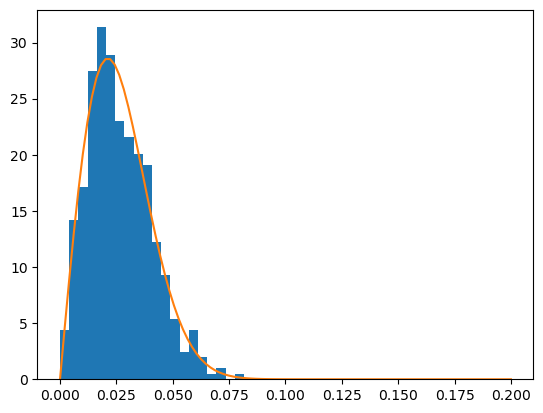

In [8]:
a = 2/V**2
x=np.linspace(0, 0.2, 100)
f_th = a*x*np.exp(-a*x**2 / 2)
plt.hist(speeds[T-1], density=True, bins=bins)
plt.plot(x, f_th)